In [1]:
import torch
import torch.nn as nn
import torch.ao.quantization
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import os, glob
import cv2
from sklearn.model_selection  import train_test_split
from sklearn.metrics import confusion_matrix
import torch.optim as optim

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import numpy as np

from torch.nn.functional import relu
import torch.nn.functional as F

from IPython.display import clear_output


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
#----------------------------------------------------------------------------------------------------------
class EncoderBlock(nn.Module):
    def __init__(self, n_input_channel, n_output_channel, pool=True):
        super().__init__()
        self.is_pool = pool
        self.block = ResidualBlock(in_channels=n_input_channel, out_channels=n_output_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        side_output = self.block(x)
        if self.is_pool:
            return self.pool(side_output), side_output
        return side_output

#-------------------------------------------------------------------------------------------------------------------
class DecoderBlock(nn.Module):
    def __init__(self, n_input_channel, n_output_channel):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(
            n_input_channel, n_output_channel, kernel_size=2, stride=2
        )
        self.block = ResidualBlock(in_channels=n_input_channel, out_channels=n_output_channel)

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        x = torch.cat([x, skip_connection], dim=1)  # concat channels
        return self.block(x)
    
#-------------------------------------------------------------------------------------------------------
class ResUNet(nn.Module):
    def __init__(self, n_class, in_channel:int=3, first_conv_out_channel:int=32, n_blocks:int=4):
        super().__init__()

        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()

        first_conv_out_channel //= 2
        self.Encoder = nn.ModuleList([])
        for i in range(n_blocks):
            self.Encoder.append(EncoderBlock(in_channel if i == 0 else first_conv_out_channel, first_conv_out_channel * 2, True))
            first_conv_out_channel *= 2
        self.BottleNeck = EncoderBlock(first_conv_out_channel, first_conv_out_channel * 2, False)
        first_conv_out_channel *= 2
        self.Decoder = nn.ModuleList([])
        for _ in range(n_blocks):
            self.Decoder.append(DecoderBlock(first_conv_out_channel, first_conv_out_channel // 2))
            first_conv_out_channel //= 2
        self.outconv = nn.Conv2d(first_conv_out_channel, n_class, kernel_size=1)

    def forward(self, x):
        x = self.quant(x)
        side_outputs = []
        for encoder in self.Encoder:
            x, side_output = encoder(x)
            side_outputs.insert(0, side_output)
        x = self.BottleNeck(x)
        for decoder, side_output in zip(self.Decoder, side_outputs):
            x = decoder(x, side_output)
        del side_outputs
        x = self.outconv(x)
        x = self.dequant(x)
        return x

# Fuse modules
def fuse_model(model):
    for m in model.modules():
        if type(m) == ResidualBlock:
            torch.ao.quantization.fuse_modules(m, [['conv1', 'bn1', 'relu'], ['conv2', 'bn2']], inplace=True)
            if m.downsample is not None:
                torch.ao.quantization.fuse_modules(m.downsample, ['0', '1'], inplace=True)


# Data loader

In [3]:
# dilation
def dilate(image, kernel_size= (3, 3)):
    kernel = np.ones(kernel_size, np.uint8)  
    return cv2.dilate(image, kernel, iterations=1)

In [4]:
image_folder_path = "/kaggle/input/farm-boundary-detection-dataset/augmented/image"
mask_folder_path = "/kaggle/input/farm-boundary-detection-dataset/augmented/mask"

# ------------------------------------------------------------------------------------

image_label_paths = []

print('Scaning data path...')

for impath in tqdm(glob.glob(os.path.join(image_folder_path,"1_*.tif"))):
    
#     if not os.path.basename(impath).startswith('1_img'):
#         continue
    
    image_id = os.path.basename(impath)
    mask_id = image_id.replace('img', 'mask')
    
    
    image_path = os.path.join(image_folder_path, image_id)
    label_path = os.path.join(mask_folder_path, mask_id)
  
    if os.path.exists(image_path) and os.path.exists(label_path):
        image_label_paths.append((image_path, label_path))

print("datasize : ", len(image_label_paths))


# ------------------------------------------------------------------------------------
# dataset class
class FarmDataset(Dataset):
    def __init__(self, image_label_paths):
        self.data = []
        self.labels = []
        
        for image_label_path in tqdm(image_label_paths):
            image, label = self.__readdata(*image_label_path)
            
            self.data.append(image)
            self.labels.append(label)
        
    def __len__(self):
        return len(self.data)
    
    def __readdata(self, imagepath, labelpath):
        image = cv2.imread(imagepath, -1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image[:256, :256, :] / 255
        image = np.transpose(image, (2, 0, 1))
        
        label = cv2.imread(labelpath, -1)
        label = label[:256, :256]
        label = dilate(label, kernel_size= (3, 3))
        
        return image, label 

    def __getitem__(self, idx):
        sample = {
            'data': torch.tensor(self.data[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return sample
    
    
# ------------------------------------------------------------------------------------
# Create an instance of the custom dataset

image_label_paths_training , image_label_paths_validation = train_test_split(image_label_paths, train_size=0.7, random_state = 2222)
print(len(image_label_paths_training), len(image_label_paths_validation))

print('loading training dataset...')
train_dataset = FarmDataset(image_label_paths_training)
print('loading validation dataset...')
validation_dataset = FarmDataset(image_label_paths_validation)

#--------------------------------------------------------------------------------
# Create a DataLoader
batch_size = 8
shuffle = True  # Whether to shuffle the data
num_workers = 4  # Number of subprocesses to use for data loading

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

Scaning data path...


  0%|          | 0/960 [00:00<?, ?it/s]

datasize :  960
672 288
loading training dataset...


  0%|          | 0/672 [00:00<?, ?it/s]

loading validation dataset...


  0%|          | 0/288 [00:00<?, ?it/s]

# Data visualization

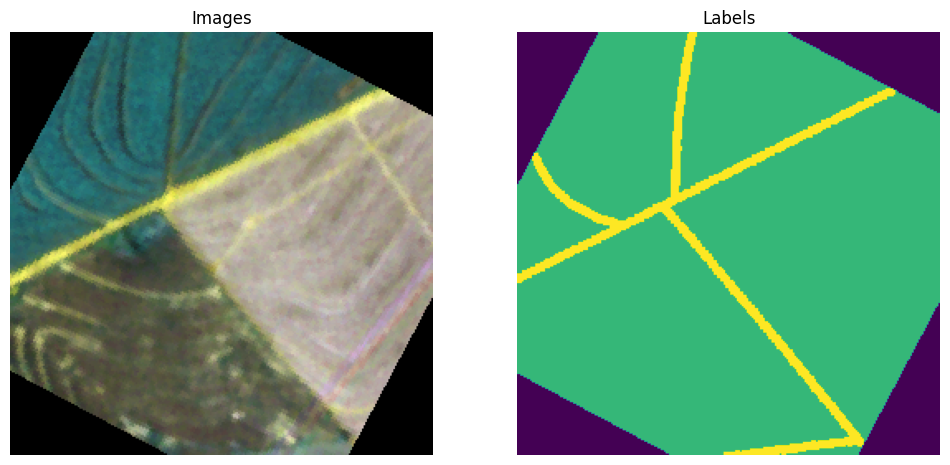

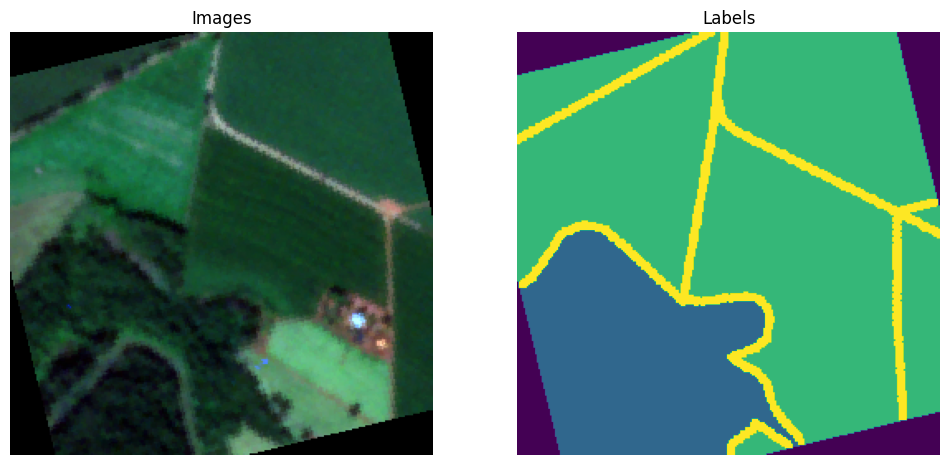

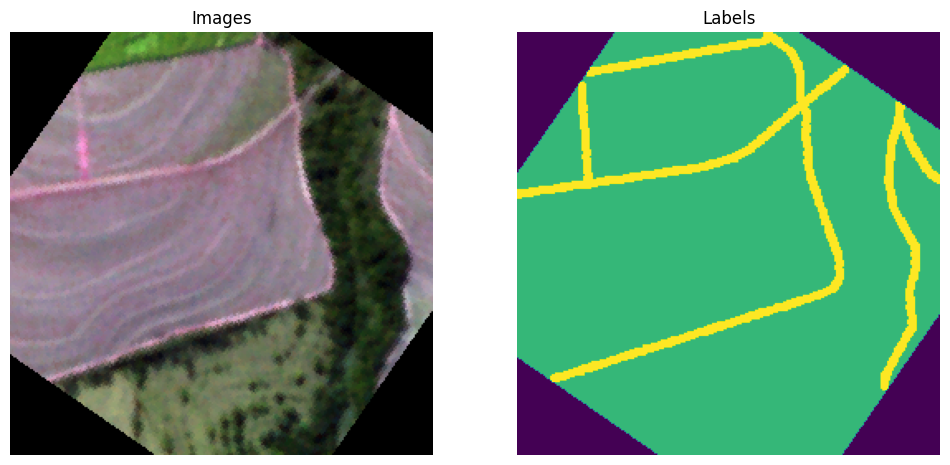

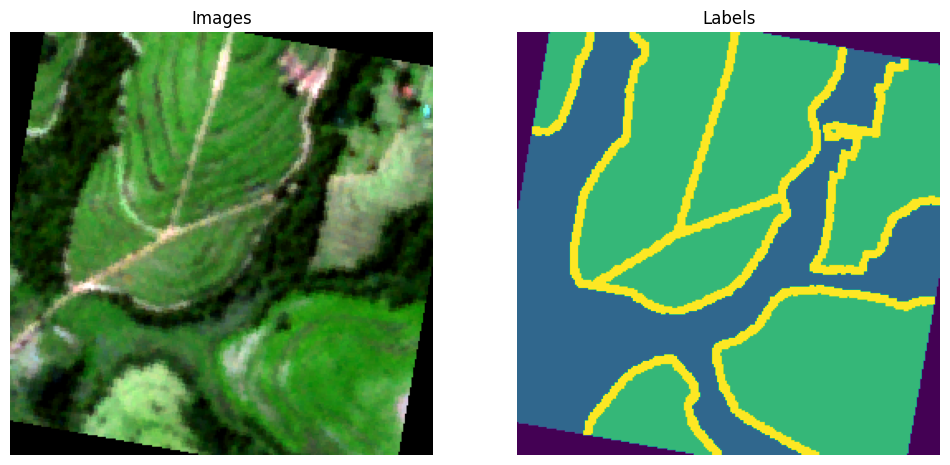

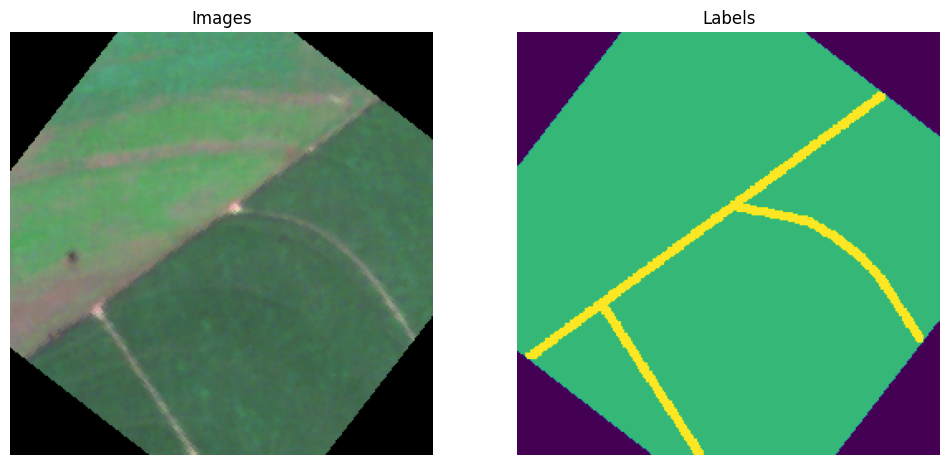

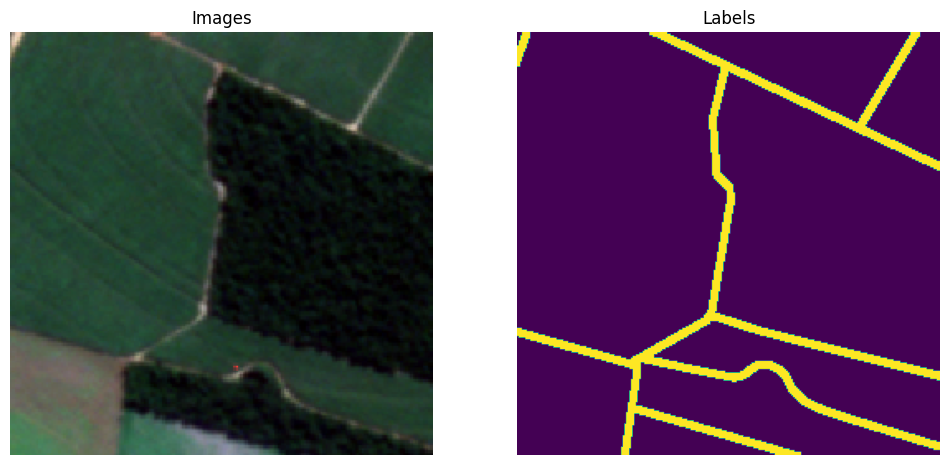

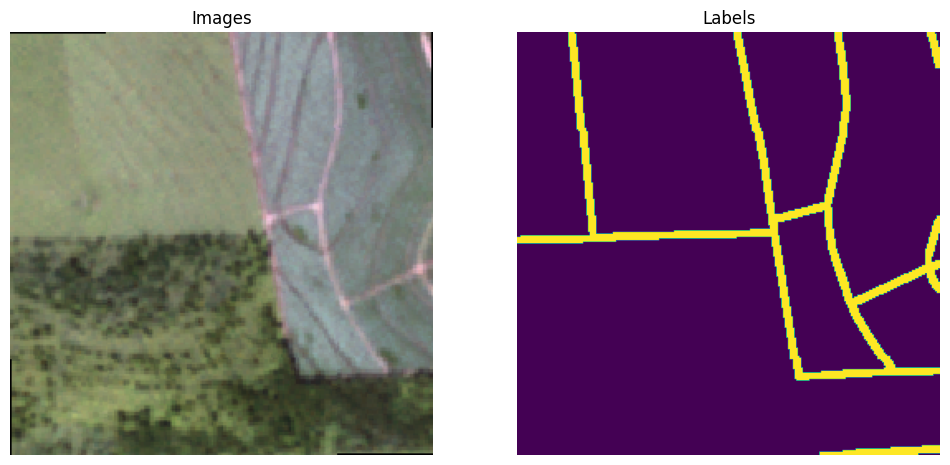

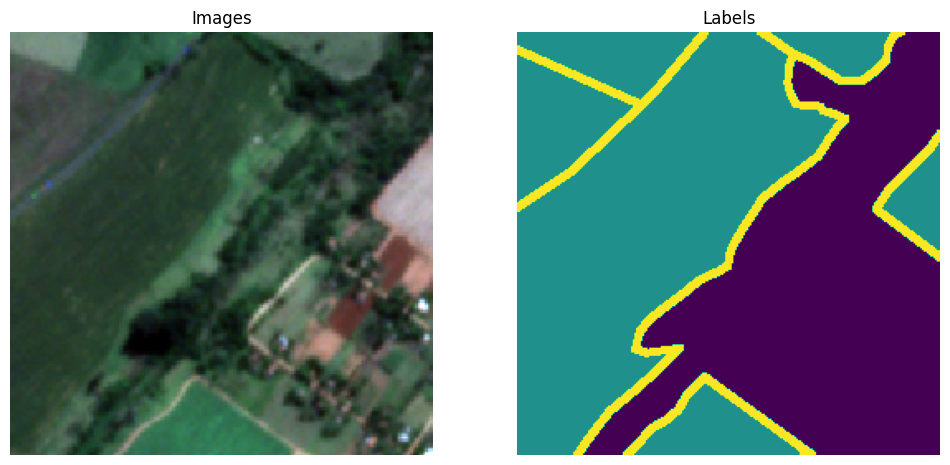

In [5]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

for batch in train_dataloader:
    images, labels = batch['data'], batch['label']
    break

# Plot each image and its corresponding label
for i in range(8):
    
    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first image
    axes[0].imshow(vutils.make_grid(images[i], normalize=True).permute(1, 2, 0))
    axes[0].set_title('Images')
    axes[0].axis('off')

    # Plot the corresponding labels (masks)
    axes[1].imshow(labels[i])
    axes[1].set_title('Labels')
    axes[1].axis('off')
    
    plt.show()


# wandb 

In [6]:
# Import the W&B Python Library
import wandb

# 1. Start a W&B Run
run = wandb.init(
    project="Farm_boundary_segmentation",
    notes="experiment-01",
    tags=["ResUNet", 'focal_loss', 'semantic-segmentation'],
)

#  2. Capture a dictionary of hyperparameters
wandb.config = {
                "epochs": 100, 
                "learning_rate": 0.0001, 
                "batch_size": 8, 
                "n_class" : 4,
                "first_conv_out_channel" : 32,
                "n_encoders" : 4
    
}

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# loss

In [7]:

class FocalLoss(nn.Module):
    def __init__(self, num_classes, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.num_classes = num_classes
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

        if alpha is None:
            self.alpha = torch.ones(num_classes)  # Default: equal weights for all classes
        else:
            assert len(alpha) == num_classes, "Length of alpha should match the number of classes"
            self.alpha = torch.tensor(alpha)
            
        self.alpha = self.alpha.to(device)

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_weights = (1 - pt) ** self.gamma
        
        alpha_c = self.alpha[targets]
        balanced_ce_loss = alpha_c * ce_loss
        focal_loss = focal_weights * balanced_ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

# training loop

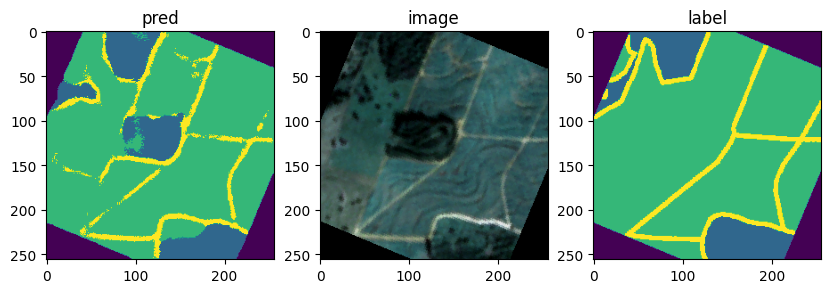

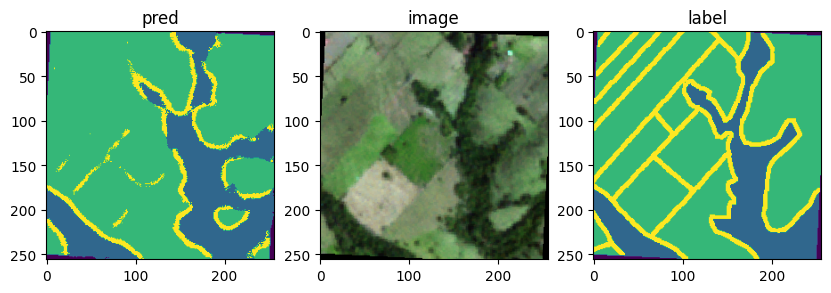

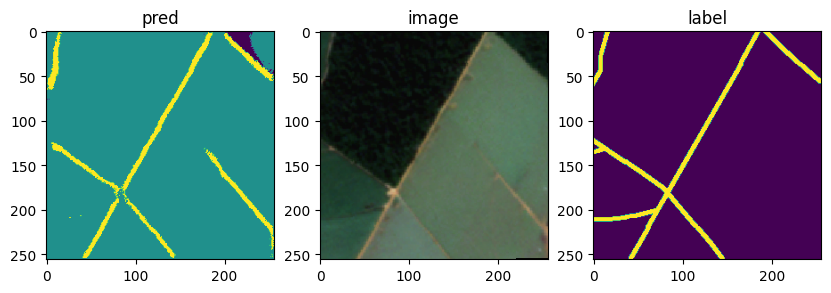

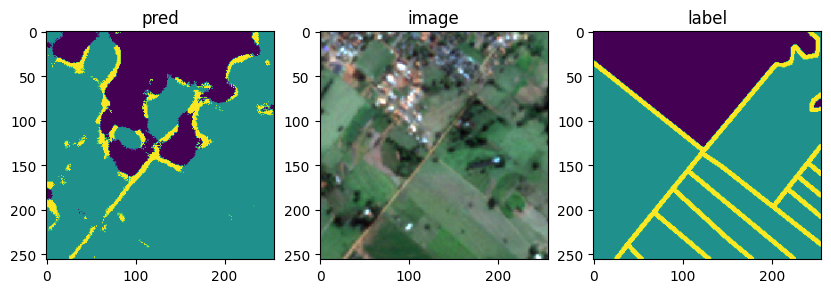

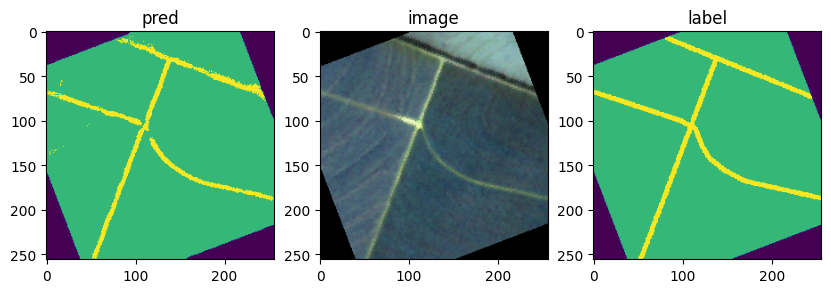

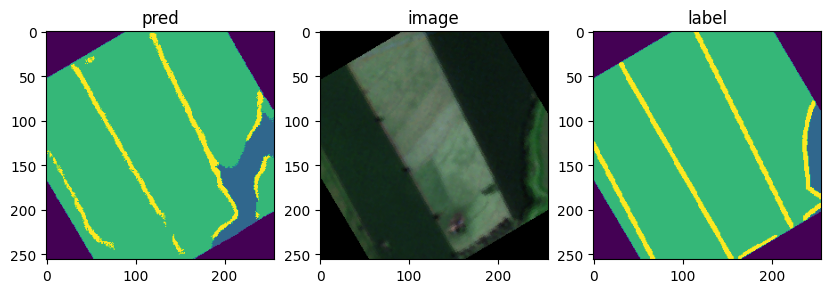

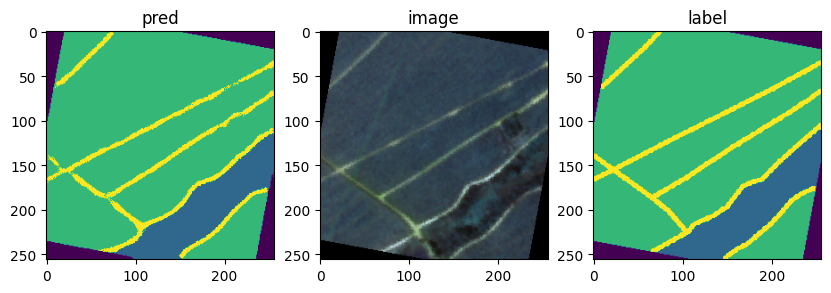

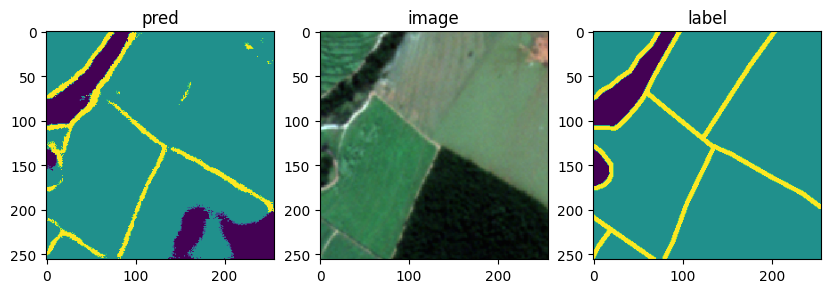

Epoch 10/10, Train Loss: 0.02284108188801578, Val Loss: 0.1461138284454743


In [10]:
# get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate and fuse the model
model_fp32 = ResUNet(n_class=4).to(device)

# set to eval for fusion to work
model_fp32.eval()
fuse_model(model_fp32)

# qconfig
model_fp32.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')

# Prepare the model for QAT. This inserts observers and fake_quants in
# the model needs to be set to train for QAT logic to work
# the model that will observe weight and activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare_qat(model_fp32.train())

# ADAM
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_fp32_prepared.parameters()), lr=0.00008)

# LOSS
# criterion = nn.CrossEntropyLoss(weight = torch.tensor([0.3636, 0.8455, 0.9273, 1.8182]))
criterion =  FocalLoss(num_classes = wandb.config['n_class'] ,alpha = [0.20, 0.6, 0.88, 1.0],gamma=2, reduction='mean')
criterion.to(device)

# Training loop
epochs = 10

for epoch in range(epochs):
    epoch_losses = []
    total_loss = 0.0
    
    # Set model to train mode
    model_fp32_prepared.train()
    
    # Iterate over DataLoader with tqdm for progress bar
    for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)):
        # Move batch to GPU
        image, label = batch['data'].to(device), batch['label'].to(device)
        
        # Forward pass
        output = model_fp32_prepared(image)
        
        # Compute loss
        loss = criterion(output, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Collect batch loss
        epoch_losses.append(loss.item())
        
        # Log training loss to WandB
        wandb.log({"Train Loss": loss.item(), "Batch": batch_idx})
    
    # Compute average training loss for the epoch
    train_loss = np.mean(epoch_losses)

    # Validation
    model_fp32_prepared.eval()
    val_losses = []
    ious = []
    with torch.no_grad():
        for val_batch in tqdm(validation_dataloader, desc=f"Validation {epoch+1}/{epochs}", leave=False):
            val_image, val_label = val_batch['data'].to(device), val_batch['label'].to(device)
            val_output = model_fp32_prepared(val_image)
            val_loss = criterion(val_output, val_label)
            val_losses.append(val_loss.item())
            
        
        # clear output
        clear_output()    
        
        ## make some visuaal
        for index in range(wandb.config['batch_size']):
            plt.figure(figsize = (10,5))
            plt.subplot(1,3,1)
            plt.imshow(val_output.softmax(1).argmax(1)[index].cpu().detach().numpy())
            plt.title('pred')
            plt.subplot(1,3,2)
            plt.imshow(np.transpose(val_image[index].cpu().detach().numpy(), (1,2,0)))
            plt.title('image')
            plt.subplot(1,3,3)
            plt.imshow(val_label[index].cpu().detach().numpy())
            plt.title('label')
            plt.show()


    # Compute average validation loss, IoU, and Dice coefficient for the epoch
    val_loss = np.mean(val_losses)

    # Log training and validation losses, IoU, and Dice coefficient to WandB
    wandb.log({"Epoch": epoch+1, "Train Loss": train_loss, "Val Loss": val_loss})

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")
    

# convert to quant

In [11]:
model_fp32_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

RuntimeError: Unsupported qscheme: per_channel_affine